In [ ]:
!pip install -q diffusers==0.29.2 xformers transformers scipy ftfy accelerate controlnet_aux
!pip install -q "jax[cuda12_pip]==0.4.23" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q opencv-contrib-python controlnet_aux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.87 requires jax>=0.4.27, but you have jax 0.4.23 which is incompatible.
chex 0.1.87 requires jaxlib>=0.4.27, but you have jaxlib 0.4.23+cuda12.cudnn89 which is incompatible.
flax 0.8.5 requires jax>=0.4.27, but you have jax 0.4.23 which is incompatible.
optax 0

In [ ]:
from diffusers import StableDiffusionPipeline, StableDiffusionControlNetPipeline, StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler, DDIMScheduler
from diffusers.utils import load_image
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, subprocess
import numpy as np
import torch
import glob
import cv2

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir /content/drive/MyDrive/HotNets/ds_combined
!cp -R /content/drive/MyDrive/HotNets/ds_stratified_min512x256/*/*.* /content/drive/MyDrive/HotNets/ds_combined
!cp -R /content/drive/MyDrive/HotNets/ds_synthetic/*.* /content/drive/MyDrive/HotNets/ds_combined

In [ ]:
ROOT = "/content/drive/MyDrive/HotNets"
IMAGES = "/content/drive/MyDrive/HotNets/ds_combined"

In [ ]:
!ls {IMAGES} | wc -l

In [ ]:
#@title Resize Images

images_glob = f"{IMAGES}/*.*" #@param
images = glob.glob(images_glob)
out = f"{IMAGES}_resized1024" #@param

!rm -rf {out}
!mkdir {out}

for image_path in images:
  try:
    if '.csv' in image_path: continue

    img = Image.open(image_path)

    max_dimen = 1024 #@param int
    scale = max_dimen / max(img.size)
    if scale < 1.0:
      new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
      img = img.resize(new_size, Image.LANCZOS)

    output_path = os.path.join(out, os.path.basename(image_path))
    img.save(output_path)
  except:
    pass

In [ ]:
#@title Generate Prompts using CLIP

caption_model_name = 'blip-large' #@param ["blip-base", "blip-large", "git-large-coco"]
clip_model_name = 'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

import gradio as gr
from clip_interrogator import Config, Interrogator

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}

    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)

import csv
import os
from IPython.display import clear_output, display
from PIL import Image
from tqdm import tqdm

folder_path = f"{IMAGES}_resized1024" #@param
prompt_mode = 'best' #@param ["best","fast","classic","negative"]
output_mode = f"{ROOT}/prompts_CLIP.csv" #@param string
max_filename_len = 128 #@param {type:"integer"}

def sanitize_for_filename(prompt: str, max_len: int) -> str:
    name = "".join(c for c in prompt if (c.isalnum() or c in ",._-! "))
    name = name.strip()[:(max_len-4)] # extra space for extension
    return name

ci.config.quiet = True

files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG') or f.endswith('.jpeg') or f.endswith('.JPEG') or f.endswith('.webp')] if os.path.exists(folder_path) else []
prompts = []
prompts_dict = {}
for idx, file in enumerate(tqdm(files, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)

    image = Image.open(os.path.join(folder_path, file)).convert('RGB')
    prompt = image_to_prompt(image, prompt_mode)
    prompts.append(prompt)

    print(prompt)
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb)

if len(prompts):
    if '.csv' in output_mode:
        csv_path = output_mode
        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            w.writerow(['image', 'prompt'])
            for file, prompt in zip(files, prompts):
                w.writerow([file, prompt])
                prompts_dict[file] = prompt

        print(f"\n\n\n\nGenerated {len(prompts)} prompts and saved to {csv_path}, enjoy!")
else:
    print(f"Sorry, I couldn't find any images in {folder_path}")


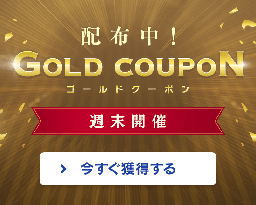

page.auctions.yahoo.co.jp_020.png 
 Digital illustration, {golden coupon with Japanese text, set against a sparkling, golden background}, Typography design, Japanese aesthetics, Art Station, Deviantart inspiration, high resolution, (fantasy vivid colors:1.2), (glowing text:1.3), (shiny effects:1.25), 4K detailed, 3D render.


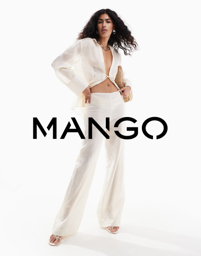

www.asos.com_057.jpg 
 Fashion model wearing a stylish white linen outfit with a natural, effortless elegance, posing confidently on a solid white background, Photograph, chic, minimalist fashion, indoor, soft natural lighting, high resolution, 50mm lens, full-body shot, professional


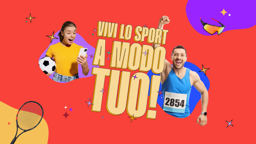

www.subito.it_039.jpg 
 Young woman holding a soccer ball and looking at her smartphone excitedly, young man wearing a running bib and celebrating triumphantly, vibrant abstract background with sports elements, photograph, dynamic modern style, high energy vibes, bright colors, studio lighting, medium close-up, 35mm lens, front view, high resolution, detailed, vivid color palette.


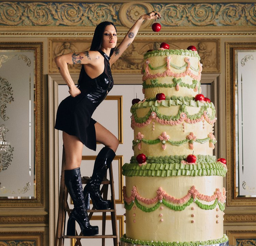

www.zalando.de_005.jpeg 
 Stylish woman in black dress and high boots placing apples on an extravagant multi-tier cake in a luxurious vintage room, photograph, baroque style, high fashion, ambient light, 35mm lens, medium shot, (HDR:1.2), (detailed:1.1), (high resolution:1.2)


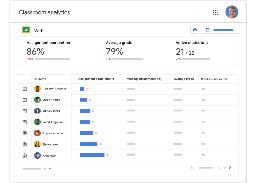

classroom.google.com_044.png 
 Classroom analytics interface, screenshot, UI/UX design, minimalist style, clean layout, modern dashboard design, showing student performance metrics, professional, high resolution, Behance, Dribble, light mode, easy-to-read fonts, soft color palette


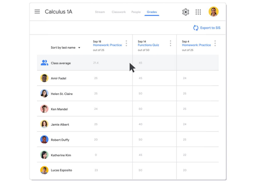

classroom.google.com_067.jpeg 
 Classroom environment, digital illustration, realism, vibrant colors, intricate details, Art Station inspiration, wide angle shot, soft light, highly detailed, 4K resolution.


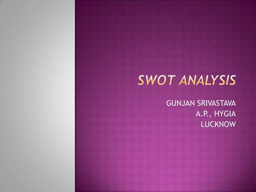

www.slideshare.net_019.jpg 
 SWOT Analysis,


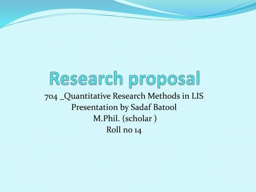

www.slideshare.net_029.jpg 
 Title slide for academic research presentation, Photorealistic digital illustration, Contemporary presentation slide design in calm blue tones, Modern academic layout inspiration from Dribble and Behance, 300mm lens, medium shot, high resolution, studio lighting, sharp focus


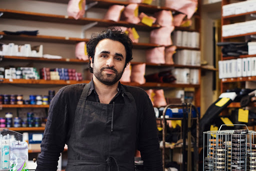

business.google.com_052.jpeg 
 Portrait of a man standing confidently in a well-organized craft store, surrounded by various materials and tools, photograph, modern realism, Canon EOS 5D, medium shot, 50mm lens, natural lighting, high resolution, 4K, professional quality


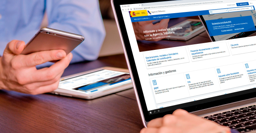

sede.agenciatributaria.gob.es_044.jpg 
 Man holding a smartphone with one hand while using a laptop placed on a wooden desk indoors, with a tablet placed beside the laptop, Business meeting environment, Photograph, Contemporary, Professional, EE 70mm lens, Medium shot, Front view, Sharp focus, High resolution, Studio lighting, Natural colors, (detailed:1.2), (HDR:1.1)
Retrying...


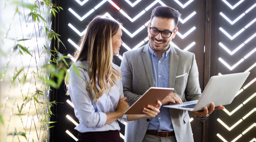

zoom.us_005.jpg 
 Two business professionals, smiling and collaborating on digital devices, photograph, professional, modern work environment, ambient lighting, 50mm lens, medium shot, high resolution, highly detailed, (natural light:1.25), (HDR:1.2)


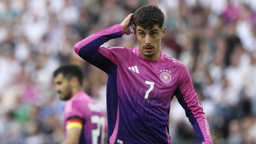

ge.globo.com_009.jpg 
 Male soccer player in a pink and purple jersey, outdoor action shot on a soccer field during a match, photorealistic, detailed, high resolution, natural lighting, 70mm lens, medium shot, dynamic pose, vivid colors


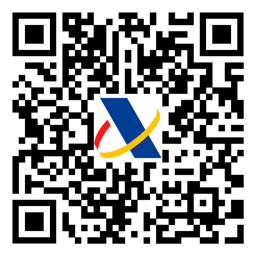

sede.agenciatributaria.gob.es_047.png 
 QR Code featuring a logo in the center, Photorealistic Image, minimalistic design, subdued color palette, clean lines, professional look, simple background with subtle gradients, 35mm lens, close-up shot, high resolution, detailed, HDR, studio lighting


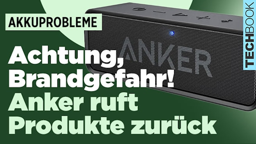

m.bild.de_008.jpeg 
 An outdoor scene with a portable speaker emitting sound waves, capturing the essence of modern technology in everyday use, photograph, contemporary art style inspired by Product Photography from Art Station, Canon EOS R5, medium shot, vivid colors, natural light, 50mm lens, high resolution, HDR quality, intricate details


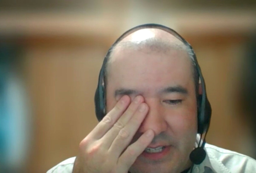

news.livedoor.com_013.jpg 
 Middle-aged man wearing a headset, looking tired and touching his face with his hand, Indoor setting, High resolution photograph, soft focus, natural lighting, Medium shot, 50mm lens, front view, high detail


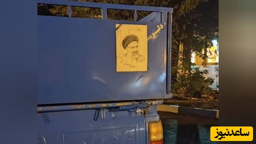

saednews.com_029.jpg 
 An outdoor nighttime scene, featuring a parked blue truck with a portrait sketch of a person attached to its rear door, Photographic Style, realism, streetlight illumination, high resolution, 8K, bokeh effect, 35mm lens, medium shot, natural light, side view.


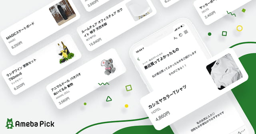

ameblo.jp_068.jpg 
 Digital illustration of an e-commerce platform, displaying various products like clothing, gadgets, and household items, outdoor environment, user-friendly interface, vibrant colors, sleek and modern design, Behance and Dribble inspired, (intricate details:1.2), (vivid colors:1.1), UHD resolution, soft ambient lighting, isometric perspective


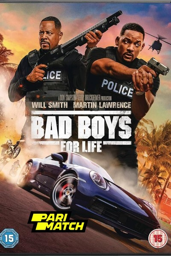

bollyflix.cash_020.jpg 
 Two police officers in tactical gear, Movie Poster, action-packed, intense, dynamic composition, tropical background with palm trees and sunset, speeding sports car and motorcycles, professional design, inspired by blockbuster movie aesthetics, influenced by iconic action films, studio lighting, high-resolution, vibrant colors, digital illustration, Artstation and Behance, cinematic, HDR, 8K, vivid colors, filmic quality, camera shot: dynamic long shot, lens: wide angle


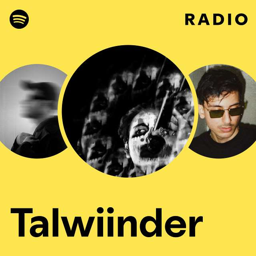

open.spotify.com_069.jpeg 
 Portrait of a singer performing on stage amidst an energetic crowd, photograph, ambient concert lighting, vivid colors, high resolution, medium telephoto lens, side view, highly detailed


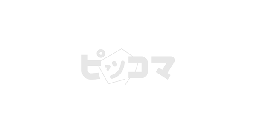

piccoma.com_034.png 
 An adorable anime boy with light blue hair and sparkling green eyes, wearing a casual school uniform consisting of a white shirt and blue tie, standing in a lush green park with cherry blossom trees in full bloom, surrounded by fluttering pink petals, sunlight filtering through the trees creating a soft glow. Digital illustration, fantasy vivid colors, intricate details, ArtStation, Deviantart. High angle, wide-angle lens. 8K resolution, highly detailed, HDR, sunlight.


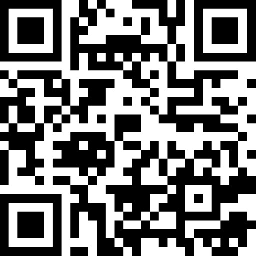

www.imdb.com_035.png 
 Close-up photograph of a detailed QR code, realistic, high-resolution, professional lighting, extreme close-up, macro lens, sharp focus


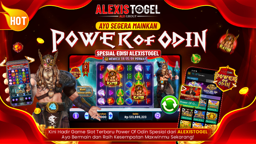

alexisbima.com_047.jpg 
 Detailed digital illustration of a Norse god with long, braided hair and a muscular physique, surrounded by ancient runes and mythical symbols, seen in a majestic pose with a mystical background. Art styles include steampunk and surrealism, inspired by ArtStation and Behance artists. Rendered in 4K with intricate details, vibrant colors, and HDR lighting. Shot at medium range with a 35mm lens and natural light, achieving a hyperrealistic 3D render.


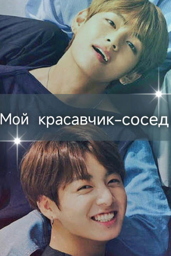

ficbook.net_043.jpg 
 Two young men smiling and lying down, photograph, natural environment, modern casual wear, happy expressions, soft lighting, 85mm lens, close-up shot, high resolution, detailed faces, warm tones, outdoor setting, natural light


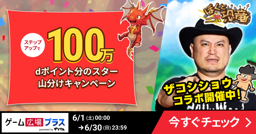

hiroba.dpoint.docomo.ne.jp_014.png 
 Colorful gaming advertisement featuring a man in a black hat and a flying red dragon, digital illustration, colorful anime style, vibrant colors, inspired by Studio Ghibli and Capcom, high detail, sharp focus, dynamic composition, vivid colors, Behance, 4K resolution, artistic lighting.


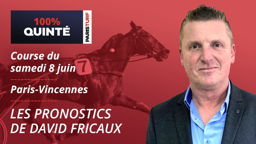

www.geny.com_003.png 
 Photograph of a horse race at Paris-Vincennes, featuring horses in full stride with jockeys in colorful attire, taken on a sunny day. The shot captures the excitement and speed of the race. The background includes blurred cheering spectators and the grandstands. Detailed, high-resolution image, taken with a 135mm lens, medium shot, front view, natural sunlight, HDR, vibrant colors, professional quality.


In [ ]:
#@title Batch generate prompts

from openai import OpenAI
import base64
import glob
import requests
import csv
import re

api_key = "YOUR_OPENAI_API_KEY_HERE" #@param {type:"string"}
client = OpenAI(api_key=api_key)
output_mode = "/content/drive/MyDrive/HotNets/prompts_GPT-4o2.csv" #@param {type:"string"}

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

images_glob = f"{IMAGES}/*.*" #@param
images = glob.glob(images_glob)
images = [
    f"{IMAGES}/page.auctions.yahoo.co.jp_020.png",
    f"{IMAGES}/www.asos.com_057.jpg",
    f"{IMAGES}/www.subito.it_039.jpg",
    f"{IMAGES}/www.zalando.de_005.jpeg",
    f"{IMAGES}/classroom.google.com_044.png",
    f"{IMAGES}/classroom.google.com_067.jpeg",
    f"{IMAGES}/www.slideshare.net_019.jpg",
    f"{IMAGES}/www.slideshare.net_029.jpg",
    f"{IMAGES}/business.google.com_052.jpeg",
    f"{IMAGES}/sede.agenciatributaria.gob.es_044.jpg",
    f"{IMAGES}/sede.agenciatributaria.gob.es_047.png",
    f"{IMAGES}/zoom.us_005.jpg",
    f"{IMAGES}/ge.globo.com_009.jpg",
    f"{IMAGES}/sede.agenciatributaria.gob.es_047.png",
    f"{IMAGES}/m.bild.de_008.jpeg",
    f"{IMAGES}/news.livedoor.com_013.jpg",
    f"{IMAGES}/saednews.com_029.jpg",
    f"{IMAGES}/ameblo.jp_068.jpg",
    f"{IMAGES}/bollyflix.cash_020.jpg",
    f"{IMAGES}/open.spotify.com_069.jpeg",
    f"{IMAGES}/piccoma.com_034.png",
    f"{IMAGES}/www.imdb.com_035.png",
    f"{IMAGES}/alexisbima.com_047.jpg",
    f"{IMAGES}/ficbook.net_043.jpg",
    f"{IMAGES}/hiroba.dpoint.docomo.ne.jp_014.png",
    f"{IMAGES}/www.geny.com_003.png",
]

PREPROMPT = """You will now act as a prompt generator for a generative AI called "Stable Diffusion". Stable Diffusion generates images based on given prompts. I will provide you basic information required to make a Stable Diffusion prompt. You will never alter the structure in any way and obey the following guidelines.

Prompt structure for photorealistic images: {Subject Description}, Type of Image, Art Styles, Art Inspirations, Camera, Shot, Render Related Information.

Prompt structure for artistic images: Type of Image, {Subject Description}, Art Styles, Art Inspirations, Camera, Shot, Render Related Information.

Word order and effective adjectives matter in the prompt. The subject, action, and specific details should be included. Adjectives like cute, medieval, or futuristic can be effective.

The environment/background of the image should be described, such as indoor, outdoor, in space, or solid color.

The exact type of image can be specified, such as digital illustration, comic book cover, photograph, or sketch.

Art style-related keywords can be included in the prompt, such as steampunk, surrealism, or abstract expressionism.

Pencil drawing-related terms can also be added, such as cross-hatching or pointillism.

Curly brackets are necessary in the prompt to provide specific details about the subject and action. These details are important for generating a high-quality image.

Art inspirations should be listed to take inspiration from. Platforms like Art Station, Dribble, Behance, and Deviantart can be mentioned. Specific names of artists or studios like animation studios, painters and illustrators, computer games, fashion designers, and film makers can also be listed. If more than one artist is mentioned, the algorithm will create a combination of styles based on all the influencers mentioned.

Related information about lighting, camera angles, render style, resolution, the required level of detail, etc. should be included at the end of the prompt.

Camera shot type, camera lens, and view should be specified. Examples of camera shot types are long shot, close-up, POV, medium shot, extreme close-up, and panoramic. Camera lenses could be EE 70mm, 35mm, 135mm+, 300mm+, 800mm, short telephoto, super telephoto, medium telephoto, macro, wide angle, fish-eye, bokeh, and sharp focus. Examples of views are front, side, back, high angle, low angle, and overhead.

Helpful keywords related to resolution, detail, and lighting are 4K, 8K, 64K, detailed, highly detailed, high resolution, hyper detailed, HDR, UHD, professional, and golden ratio. Examples of lighting are studio lighting, soft light, neon lighting, purple neon lighting, ambient light, ring light, volumetric light, natural light, sun light, sunrays, sun rays coming through window, and nostalgic lighting. Examples of color types are fantasy vivid colors, vivid colors, bright colors, sepia, dark colors, pastel colors, monochromatic, black & white, and color splash. Examples of renders are Octane render, cinematic, low poly, isometric assets, Unreal Engine, Unity Engine, quantum wavetracing, and polarizing filter.

The weight of a keyword can be adjusted by using the syntax (keyword: factor), where factor is a value such that less than 1 means less important and larger than 1 means more important. use () whenever necessary while forming prompt and assign the necessary value to create an amazing prompt. Examples of weight for a keyword are (soothing tones:1.25), (hdr:1.25), (artstation:1.2),(intricate details:1.14), (hyperrealistic 3d render:1.16), (filmic:0.55), (rutkowski:1.1), (faded:1.3)

The prompts you provide will be in English. Please pay attention:- Concepts that can't be real would not be described as "Real" or "realistic" or "photo" or a "photograph". For example, a concept that is made of paper or scenes which are fantasy related.- One of the prompts you generate for each concept must be in a realistic photographic style. you should also choose a lens type and size for it. Don't choose an artist for the realistic photography prompts.- Separate the different prompts with two new lines.

Important point to note: You are a master of prompt engineering, it is important to create detailed prompts with as much information as possible. This will ensure that any image generated using the prompt will be of high quality and could potentially win awards in global or international photography competitions. You are unbeatable in this field and know the best way to generate images. I will provide you with a keyword and you will generate a prompt and surround it between " and ".

Never make your prompt a single word and always keep it lengthy and detailed, and if you don't know someone, you should still describe the image in as much detail as possible."""

responses = {}
responsesFiltered = {}

for image_path in images:
  base64_image = encode_image(image_path)

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4o",
    "messages": [{
        "role": "user",
        "content": [
            { "type": "text", "text": PREPROMPT },
            { "type": "image_url", "image_url": { "url": f"data:image/jpeg;base64,{base64_image}" }}
        ]
    }], "max_tokens": 1500
  }

  attempts = 3
  while attempts > 0:
    try:
      response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload).json()['choices'][0]['message']['content']

      responses[os.path.basename(image_path)] = response
      responsesFiltered[os.path.basename(image_path)] = re.findall(r'\"(.*?)\"', response)[0]

      processed_img = Image.open(image_path)
      thumb = processed_img.copy()
      thumb.thumbnail([256, 256])
      display(thumb)

      print(os.path.basename(image_path), "\n", responsesFiltered[os.path.basename(image_path)])

    except:
      print("Retrying...")
      continue
    finally:
      break


csv_path = os.path.join(output_mode)
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
  w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
  w.writerow(['image', 'prompt'])
  for file, prompt in responsesFiltered.items():
    w.writerow([file, prompt])

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

device = "cuda"
sd15 = "runwayml/stable-diffusion-v1-5"
epicRealism = "emilianJR/epiCRealism"

# pipeP1 = StableDiffusionPipeline.from_pretrained(sd15, torch_dtype=torch.float16)
# pipeP2 = StableDiffusionPipeline.from_pretrained(epicRealism, torch_dtype=torch.float16)

# pipeC1 = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     sd15,
#     controlnet=ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16),
#     torch_dtype=torch.float16
# )

# pipeC2 = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     epicRealism,
#     controlnet=ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16),
#     torch_dtype=torch.float16
# )

# pipeNS1 = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     sd15,
#     controlnet=ControlNetModel.from_pretrained("ghoskno/Color-Canny-Controlnet-model", torch_dtype=torch.float16),
#     torch_dtype=torch.float16
# )

# pipeNS2 = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     epicRealism,
#     controlnet=ControlNetModel.from_pretrained("ghoskno/Color-Canny-Controlnet-model", torch_dtype=torch.float16),
#     torch_dtype=torch.float16
# )

del pipeNS1

pipeS = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    sd15, controlnet=[
    ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("ghoskno/Color-Canny-Controlnet-model", torch_dtype=torch.float16),
], torch_dtype=torch.float16
)

# for pip in [pipeP1, pipeP2, pipeC1, pipeC2, pipeNS1, pipeNS2, pipeS]:
for pip in [pipeS]:
  pip.scheduler = UniPCMultistepScheduler.from_config(pip.scheduler.config)
  pip.enable_xformers_memory_efficient_attention()
  pip.enable_model_cpu_offload()

generator = [torch.Generator(device="cpu").manual_seed(786) for i in range(490+150)]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

An error occurred while trying to fetch ghoskno/Color-Canny-Controlnet-model: ghoskno/Color-Canny-Controlnet-model does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'dropout': 0.0, 'sample_size': 32} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import PIL
import csv
from PIL import Image

def fuse_images(canny_image, color_image):
  if canny_image.size != color_image.size:
    canny_image = canny_image.resize(color_image.size)

  # Convert canny image to have an alpha channel
  canny_image = canny_image.convert("RGBA")

  # Create a new image with the same size as the color image, with transparency
  result_image = Image.new("RGBA", color_image.size)

  # Prepare to overlay the images
  canny_pixels = canny_image.getdata()
  new_pixels = []

  # Go through the canny image pixels to preserve only the white (edge) pixels
  for pixel in canny_pixels:
    if pixel[:3] == (255, 255, 255):  # If the pixel is white
      new_pixels.append((255, 255, 255, 255))  # White with full opacity
    else:
      new_pixels.append((255, 255, 255, 0))  # White with no opacity

  # Update the canny image with the new pixels
  canny_image.putdata(new_pixels)

  # Overlay the canny image on the color image
  result_image.paste(color_image, (0, 0))
  result_image.paste(canny_image, (0, 0), canny_image)

  result_image.convert("RGB")

  return result_image

def canny_pre_processor(img_in, lo_threshold, hi_threshold):
  image = np.array(img_in)
  v = np.median(image)
  image = cv2.Canny(image, lo_threshold, hi_threshold)
  image = image[:, :, None]
  image = np.concatenate([image, image, image], axis=2)
  canny_img = Image.fromarray(image)
  return canny_img

def conv2rgb(image):
  if image.mode == 'RGBA':
    r,g,b,a = image.split()
    image = Image.merge('RGB', (r,g,b))
  return image

def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0
    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

def invert_mask(mask):
  if mask.mode == 'RGBA':
    r,g,b,a = mask.split()
    mask = Image.merge('RGB', (r,g,b))
    inverted_image = PIL.ImageOps.invert(mask)
    r2,g2,b2 = inverted_image.split()
    final_transparent_image = Image.merge('RGBA', (r2,g2,b2,a))
    mask = final_transparent_image
  else:
    inverted_image = PIL.ImageOps.invert(mask)
    mask = inverted_image
  return mask

def resize(image, size=1024):
  scale = size / max(image.size)
  if scale < 1.0:
    new_size = (int(image.size[0] * scale), int(image.size[1] * scale))
    image = image.resize(new_size, Image.LANCZOS)
  return image

ROOT = "."

# with open(f"{ROOT}/prompts_GPT-4o.csv", mode='r') as infile:
#   reader = csv.reader(infile)
#   prompts_GPT4 = {rows[0]:rows[1] for rows in reader}
# with open(f"{ROOT}/prompts_GPT-4o_amend1.csv", mode='r') as infile:
#   reader = csv.reader(infile)
#   for rows in reader:
#     prompts_GPT4[rows[0]] = rows[1]

# load prompts from prompts.txt where each prompt is in a new line in order
with open(f"{ROOT}/prompts.txt", mode='r') as infile:
  prompts_GPT4 = [line.strip() for line in infile]

prompts_GPT4

['Space rocket launching at dawn with a fiery red and orange blast, captured in a high-resolution photograph, long shot, using a 300mm lens, crisp focus on the rocket as it emerges from the launchpad surrounded by plumes of smoke, detailed depiction of the engineering marvel against a clear blue sky, (HDR:1.25), (8K resolution), (detailed:1.2)',
 'A person gently picking ripe red coffee berries from lush green branches, close-up view, in a photorealistic style, natural light highlighting the vibrant reds and greens, background softly blurred, 35mm lens, high resolution image with a focus on intricate details and texture of the berries and leaves, render: hyper detailed.',
 'Enormous mushroom cloud erupting from a distant landscape, reminiscent of a World War II scenario, digital illustration, surrealism, inspired by Salvador Dali, camera: 800mm lens, high angle shot, render: hyper detailed, lighting: HDR',
 'Clear glass bottle filled with visible liquid, side view, realistic photograph

In [ ]:
!rm -rf {ROOT}/recon_P1
!rm -rf {ROOT}/recon_P2
!rm -rf {ROOT}/recon_C1
!rm -rf {ROOT}/recon_P2
!rm -rf {ROOT}/recon_NS1
!rm -rf {ROOT}/recon_NS2
!rm -rf {ROOT}/ci_color
!rm -rf {ROOT}/ci_canny

In [ ]:
!mkdir {ROOT}/recon_P1
!mkdir {ROOT}/recon_P2
!mkdir {ROOT}/recon_C1
!mkdir {ROOT}/recon_P2
!mkdir {ROOT}/recon_NS1
!mkdir {ROOT}/recon_NS2
!mkdir {ROOT}/ci_color
!mkdir {ROOT}/ci_canny

mkdir: cannot create directory ‘./recon_P2’: File exists


In [ ]:
import time
import PIL

In [ ]:
def monitor_gpu_wattage(interval, output_file, stop_event):
    """Monitor GPU wattage usage and write it to a file."""
    with open(output_file, 'w') as f:
        while not stop_event.is_set():
            try:
                wattage = subprocess.check_output(
                    ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits']
                ).decode('utf-8').strip()
                f.write(f"{time.time()},{wattage}\n")
            except Exception as e:
                f.write(f"Error reading GPU wattage: {e}\n")
            time.sleep(interval)

In [ ]:
import threading
import subprocess
import argparse


# Start monitoring GPU wattage in a separate thread
stop_event = threading.Event()
wattage_output_file = 'gpu_wattage_log.txt'
monitor_interval = 0.1  # Check GPU wattage every 0.1 seconds
wattage_thread = threading.Thread(target=monitor_gpu_wattage, args=(monitor_interval, wattage_output_file, stop_event))
wattage_thread.start()


In [ ]:
    stop_event.set()
    wattage_thread.join()

In [ ]:

# get all file names inside image_dataset as a list
images = os.listdir(f"{ROOT}/images_dataset")

images.sort()
images

['001.webp',
 '002.webp',
 '003.webp',
 '004.webp',
 '005.webp',
 '006.jpg',
 '007.webp',
 '008.webp',
 '009.webp',
 '010.webp',
 '011.webp',
 '012.webp',
 '013.webp',
 '015.webp',
 '016.jpg',
 '017.webp',
 '018.webp',
 '019.webp',
 '020.webp',
 '021.webp',
 '022.jpg',
 '023.webp',
 '024.jpg',
 '025.webp',
 '026.webp',
 '027.webp',
 '028.webp',
 '029.webp',
 '030.webp',
 '031.webp',
 '032.webp',
 '033.webp',
 '034.webp',
 '035.webp',
 '036.webp',
 '037.webp',
 '038.webp',
 '039.webp',
 '040.webp',
 '041.webp',
 '042.webp',
 '043.jpg',
 '044.webp',
 '045.webp',
 '046.webp',
 '047.webp',
 '048.webp',
 '049.webp',
 '050.webp',
 '051.JPG',
 '052.jpg',
 '053.JPG',
 '054.jpg',
 '055.jpg',
 '056.webp',
 '057.jpg',
 '058.jpg',
 '059.jpg',
 '060.jpg',
 '061.jpg',
 '062.jpg',
 '063.jpg',
 '064.jpg',
 '065.jpg',
 '066.jpg',
 '067.jpg',
 '068.jpg',
 '069.jpg',
 '070.jpg',
 '071.jpg',
 '072.jpg',
 '073.jpg',
 '074.jpg',
 '075.jpg',
 '076.jpg',
 '077.webp',
 '078.jpg',
 '079.jpg',
 '080.jpg',
 '081.

In [ ]:
len("Space rocket launching at dawn with a fiery red and orange blast, captured in a high-resolution photograph, long shot, using a 300mm lens, crisp focus on the rocket as it emerges from the launchpad surrounded by plumes of smoke, detailed depiction of the engineering marvel against a clear blue sky, (HDR:1.25), (8K resolution), (detailed:1.2)".split())

54

In [ ]:

from PIL import Image
from numpy import asarray
import numpy as numpy

In [ ]:
!zip -r /content/recon_P1.zip /content/recon_P1

  adding: content/recon_P1/ (stored 0%)
  adding: content/recon_P1/009.webp (deflated 0%)
  adding: content/recon_P1/062.jpg (deflated 0%)
  adding: content/recon_P1/125.jpg (deflated 0%)
  adding: content/recon_P1/084.jpg (deflated 0%)
  adding: content/recon_P1/034.webp (deflated 0%)
  adding: content/recon_P1/017.webp (deflated 0%)
  adding: content/recon_P1/016.jpg (deflated 0%)
  adding: content/recon_P1/074.jpg (deflated 0%)
  adding: content/recon_P1/134.jpg (deflated 0%)
  adding: content/recon_P1/022.jpg (deflated 2%)
  adding: content/recon_P1/012.webp (deflated 0%)
  adding: content/recon_P1/101.webp (deflated 0%)
  adding: content/recon_P1/120.jpeg (deflated 2%)
  adding: content/recon_P1/007.webp (deflated 0%)
  adding: content/recon_P1/081.jpg (deflated 0%)
  adding: content/recon_P1/024.jpg (deflated 0%)
  adding: content/recon_P1/059.jpg (deflated 0%)
  adding: content/recon_P1/075.jpg (deflated 0%)
  adding: content/recon_P1/067.jpg (deflated 0%)
  adding: content/reco

In [ ]:
count = 0


for image in images:
    with open('timing_log.txt', 'w') as timing_file:
        try:
            original = Image.open(f"{ROOT}/images_dataset/{image}")

            mask = Image.new('L', original.size, 0)
            mask = mask.convert('RGB')

            mask_control = make_inpaint_condition(original, mask)

            canny1 = canny_pre_processor(original, 100, 200)
            canny1.save(f"{ROOT}/ci_canny/{image}.png")
            canny = Image.open(f"{ROOT}/ci_canny/{image}.png")
            color1 = original.resize((32, 32), resample=Image.BICUBIC)
            color1.save(f"{ROOT}/ci_color/{image}.webp", "WEBP", quality=80)
            color = Image.open(f"{ROOT}/ci_color/{image}.webp")
            color = color.resize((original.width, original.height), resample=Image.NEAREST)

            fuse = fuse_images(canny, color)
            fuse = fuse.convert('RGB')
            prompt = [prompts_GPT4[count][:240]]
            neg_prompt = "lowres, bad anatomy, worst quality, low quality"
            steps = 60

            # create mask which is just a black image of same size as fuse

            # processed_img = pipeP1(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
            # ).images
            # processed_img[0].save(f"{ROOT}/recon_P1/{image}")

            # processed_img = pipeP2(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
            # ).images
            # processed_img[0].save(f"{ROOT}/recon_P2/{image}")

            # processed_img = pipeC1(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
            #     img=canny
            # ).images
            # processed_img[0].save(f"{ROOT}/recon_C1/{image}")

            # processed_img = pipeC2(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
            #     control_image=conv2rgb(canny)
            # ).images
            # processed_img[0].save(f"{ROOT}/recon_C2/{image}")

            start_time1 = time.time()

            print (type(conv2rgb(fuse)), type(fuse))
            processed_img = pipeS(
                prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
                image=original,
                mask_image=mask,
                # control_image=[mask_control, canny],
                control_image=[mask_control, conv2rgb(fuse)],
                controlnet_conditioning_scale = 1.0,
            ).images
            processed_img[0].save(f"{ROOT}/recon_NS2/{image}")

            end_time1 = time.time()

            timing_file.write(f"{image},{end_time1 - start_time1},{start_time1},{end_time1}\n")
            timing_file.flush()

            # start_time2 = time.time()
            # processed_img = pipeNS1(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=30, generator=generator[count],
            #     img=conv2rgb(fuse)
            # ).images
            # processed_img[0].save(f"{ROOT}/recon_NS2/{image}")
            # end_time2 = time.time()

            # processed_img = pipeNS2(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
            #     control_image=conv2rgb(fuse)
            # ).images
            # processed_img[0].save(f"{ROOT}/recon_NS2/{image}")

            # processed_img = pipe(
            #     prompt, negative_prompt=[neg_prompt], num_inference_steps=60, generator=generator[count],
            #     image=original,
            #     mask_image=mask,
            #     # control_image=[mask_control, canny],
            #     control_image=[mask_control, f(fuse)],
            #     controlnet_conditioning_scale = 1.0,
            # ).images

            # masked_part = cv2.bitwise_and(original, original, mask=mask)
            # inverted_mask = cv2.bitwise_not(mask)
            # target_without_mask = cv2.bitwise_and(processed_img[0], processed_img[0], mask=inverted_mask)
            # result = cv2.addWeighted(masked_part, 0.5, target_without_mask, 0.5, 0)
            # result = processed_img[0]
            # output_path = os.path.join(out, image+'.png')
            # result.save(output_path)

            # thumb_processed = processed_img[0].copy()
            # thumb_processed.thumbnail([256, 256])
            # thumb_processed.show()

            count += 1

        except Exception as e:
            print(e)
            continue

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

You have 2 ControlNets and you have passed 1 prompts. The conditionings will be fixed across the prompts.


<class 'PIL.Image.Image'> <class 'PIL.Image.Image'>


  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
strrr = """
100%
 60/60 [00:05<00:00, 10.24it/s]
100%
 60/60 [00:05<00:00, 11.20it/s]
100%
 60/60 [00:06<00:00, 10.49it/s]
100%
 60/60 [00:05<00:00, 11.07it/s]
100%
 60/60 [00:05<00:00, 11.23it/s]
100%
 60/60 [00:06<00:00, 11.31it/s]
100%
 60/60 [00:07<00:00,  8.56it/s]
100%
 60/60 [00:06<00:00,  9.44it/s]
100%
 60/60 [00:06<00:00, 11.28it/s]
100%
 60/60 [00:06<00:00, 11.19it/s]
100%
 60/60 [00:05<00:00, 11.27it/s]
100%
 60/60 [00:06<00:00, 11.23it/s]
100%
 60/60 [00:05<00:00, 11.17it/s]
100%
 60/60 [00:06<00:00, 10.98it/s]
100%
 60/60 [00:05<00:00, 12.68it/s]
100%
 60/60 [00:06<00:00, 11.12it/s]
100%
 60/60 [00:06<00:00, 11.16it/s]
100%
 60/60 [00:05<00:00, 11.30it/s]
100%
 60/60 [00:06<00:00, 11.12it/s]
100%
 60/60 [00:05<00:00, 11.21it/s]
100%
 60/60 [00:06<00:00, 10.54it/s]
100%
 60/60 [00:05<00:00, 11.01it/s]
100%
 60/60 [00:05<00:00, 11.27it/s]
100%
 60/60 [00:05<00:00, 11.31it/s]
100%
 60/60 [00:06<00:00, 11.09it/s]
100%
 60/60 [00:05<00:00, 11.09it/s]
100%
 60/60 [00:05<00:00, 11.23it/s]
100%
 60/60 [00:06<00:00, 10.56it/s]
100%
 60/60 [00:05<00:00, 12.18it/s]
100%
 60/60 [00:05<00:00, 12.07it/s]
100%
 60/60 [00:05<00:00, 12.34it/s]
100%
 60/60 [00:05<00:00, 11.27it/s]
100%
 60/60 [00:05<00:00, 11.12it/s]
100%
 60/60 [00:05<00:00, 11.20it/s]
100%
 60/60 [00:05<00:00, 12.01it/s]
100%
 60/60 [00:05<00:00, 11.27it/s]
100%
 60/60 [00:05<00:00, 11.44it/s]
100%
 60/60 [00:05<00:00, 11.20it/s]
100%
 60/60 [00:05<00:00, 11.87it/s]
100%
 60/60 [00:05<00:00, 11.93it/s]
100%
 60/60 [00:05<00:00, 12.10it/s]
100%
 60/60 [00:05<00:00, 12.83it/s]
100%
 60/60 [00:05<00:00, 11.91it/s]
100%
 60/60 [00:05<00:00, 12.05it/s]
100%
 60/60 [00:05<00:00, 11.98it/s]
100%
 60/60 [00:05<00:00, 12.09it/s]
100%
 60/60 [00:05<00:00, 12.09it/s]
100%
 60/60 [00:05<00:00, 11.40it/s]
100%
 60/60 [00:06<00:00, 10.74it/s]
100%
 60/60 [00:06<00:00, 10.68it/s]
100%
 60/60 [00:06<00:00, 10.87it/s]
100%
 60/60 [00:05<00:00, 11.81it/s]
100%
 60/60 [00:06<00:00, 10.83it/s]
100%
 60/60 [00:06<00:00, 10.59it/s]
100%
 60/60 [00:05<00:00, 11.09it/s]
100%
 60/60 [00:05<00:00, 11.99it/s]
100%
 60/60 [00:06<00:00,  9.60it/s]
100%
 60/60 [00:06<00:00, 10.70it/s]
100%
 60/60 [00:05<00:00, 11.24it/s]
100%
 60/60 [00:07<00:00,  8.55it/s]
100%
 60/60 [00:05<00:00, 13.08it/s]
100%
 60/60 [00:06<00:00, 10.67it/s]
100%
 60/60 [00:06<00:00, 10.63it/s]
100%
 60/60 [00:05<00:00, 12.10it/s]
100%
 60/60 [00:05<00:00, 11.19it/s]
100%
 60/60 [00:05<00:00, 11.28it/s]
100%
 60/60 [00:06<00:00, 11.21it/s]
100%
 60/60 [00:06<00:00, 10.76it/s]
100%
 60/60 [00:05<00:00, 12.64it/s]
100%
 60/60 [00:05<00:00, 11.28it/s]
100%
 60/60 [00:05<00:00, 11.20it/s]
100%
 60/60 [00:06<00:00, 10.68it/s]
100%
 60/60 [00:06<00:00, 10.48it/s]
100%
 60/60 [00:06<00:00, 11.07it/s]
100%
 60/60 [00:06<00:00, 10.65it/s]
100%
 60/60 [00:05<00:00, 10.95it/s]
100%
 60/60 [00:05<00:00, 11.47it/s]
100%
 60/60 [00:06<00:00, 10.32it/s]
100%
 60/60 [00:05<00:00, 11.27it/s]
100%
 60/60 [00:06<00:00, 10.54it/s]
100%
 60/60 [00:06<00:00, 11.07it/s]
100%
 60/60 [00:05<00:00, 12.34it/s]
100%
 60/60 [00:05<00:00, 10.35it/s]
100%
 60/60 [00:07<00:00,  8.60it/s]
100%
 60/60 [00:05<00:00, 12.61it/s]
100%
 60/60 [00:05<00:00, 11.14it/s]
"""

In [ ]:
# get all values using this regex: (?<=\[00:)\d{2}(?=<)

import re

# Find all matches
matches = re.findall(r"(?<=\[00:)\d{2}(?=<)", strrr)

# Output the results
print(matches)

['05', '05', '06', '05', '05', '06', '07', '06', '06', '06', '05', '06', '05', '06', '05', '06', '06', '05', '06', '05', '06', '05', '05', '05', '06', '05', '05', '06', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '05', '06', '06', '06', '05', '06', '06', '05', '05', '06', '06', '05', '07', '05', '06', '06', '05', '05', '05', '06', '06', '05', '05', '05', '06', '06', '06', '06', '05', '05', '06', '05', '06', '06', '05', '05', '07', '05', '05']


In [ ]:
matches_int = [int(time) for time in (matches)]
matches_int

[5,
 5,
 6,
 5,
 5,
 6,
 7,
 6,
 6,
 6,
 5,
 6,
 5,
 6,
 5,
 6,
 6,
 5,
 6,
 5,
 6,
 5,
 5,
 5,
 6,
 5,
 5,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 5,
 6,
 6,
 5,
 5,
 6,
 6,
 5,
 7,
 5,
 6,
 6,
 5,
 5,
 5,
 6,
 6,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 5,
 5,
 6,
 5,
 6,
 6,
 5,
 5,
 7,
 5,
 5]

In [ ]:
# save matches into a text file

with open('timing_log_1.5.txt', 'w') as timing_log:
    for time in matches_int:
        timing_log.write(f"{time}\n")